In [42]:
import re

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, OrdinalEncoder, OneHotEncoder

some helper functions

In [43]:
def get_vcf_df(vcf_fp, stop_on='#CHROM'):
    f = open(vcf_fp)

    line = ''
    header = ''
    while True:
        line = f.readline()
        if line[:6] == stop_on:
            break
            
    df = pd.read_csv(f, sep='\t', header=None)
    df.columns = line[1:].strip().replace('""', '').split('\t')
    df.index = df['ID']
    df.index.name = ''
    
    # remove X chromosome
    df = df[df['CHROM'] != 'X']
    
    # grab the columns we want
    df = df[df.columns[9:]]

    # transpose dataframe so samples are rows, mutations are columns
    df = df.transpose()

    sample_ids = list(df.index)
    
    f.close()
    
    return df, sample_ids

In [44]:
abbr_to_full = {
    'EUR': 'european',
    'AFR': 'african',
    'SAS': 'south asian',
    'EAS': 'east asian',
    'AMR': 'south/north american'
}
def get_ancestry_map(map_fp):
    f = open(map_fp)
    
    # dump header
    f.readline()
    
    ancestry_map = {}
    for line in f:
        sample_id, ancestry = line.strip().split('\t')
        
        # replace ancestry with full name
        ancestry = abbr_to_full[ancestry]
        
        ancestry_map[sample_id] = ancestry
        
    
    return ancestry_map

## Data Preprocessing

In [45]:
# read in 1000 Genomes Project data
genomes_vcf_fp = 'data/1000_genomes.vcf'
df, sample_ids = get_vcf_df(genomes_vcf_fp)

df.head()

,rs1052751,rs2230862,rs17279712,rs76321590,rs3813050,rs35039186,rs150393208,rs77400748,rs1468512,rs2288370,...,rs6591182,rs758773,rs117535467,rs10195,rs6062207,rs11253156,rs117893942,rs7247504,rs6006988,rs576619
HG00096,0|0,0|0,0|0,0|0,0|1,0|0,0|0,0|0,0|0,1|0,...,0|1,1|1,0|0,0|0,0|0,0|1,0|0,1|0,0|0,0|0
HG00097,0|1,1|1,0|0,0|0,1|0,0|0,0|0,0|0,0|1,0|0,...,1|1,0|0,0|0,0|0,0|0,1|1,0|0,1|0,0|0,0|0
HG00099,0|1,1|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|1,...,0|0,0|1,0|0,0|0,0|0,1|1,0|1,1|0,0|0,1|1
HG00100,1|0,0|1,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,...,1|0,0|0,0|0,0|0,0|0,1|1,0|0,0|1,0|0,0|0
HG00101,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,...,0|1,0|1,0|0,0|0,0|0,1|0,0|0,0|1,0|0,0|0


In [46]:
# replace phased calls
df = df.replace(re.compile(r'^1\|0'), '0|1')

df.head()

,rs1052751,rs2230862,rs17279712,rs76321590,rs3813050,rs35039186,rs150393208,rs77400748,rs1468512,rs2288370,...,rs6591182,rs758773,rs117535467,rs10195,rs6062207,rs11253156,rs117893942,rs7247504,rs6006988,rs576619
HG00096,0|0,0|0,0|0,0|0,0|1,0|0,0|0,0|0,0|0,0|1,...,0|1,1|1,0|0,0|0,0|0,0|1,0|0,0|1,0|0,0|0
HG00097,0|1,1|1,0|0,0|0,0|1,0|0,0|0,0|0,0|1,0|0,...,1|1,0|0,0|0,0|0,0|0,1|1,0|0,0|1,0|0,0|0
HG00099,0|1,0|1,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|1,...,0|0,0|1,0|0,0|0,0|0,1|1,0|1,0|1,0|0,1|1
HG00100,0|1,0|1,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,...,0|1,0|0,0|0,0|0,0|0,1|1,0|0,0|1,0|0,0|0
HG00101,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,...,0|1,0|1,0|0,0|0,0|0,0|1,0|0,0|1,0|0,0|0


In [47]:
# read in ancestries for samples
ancestry_map_fp = 'data/ancestry_map.tsv'
sample_id_to_ancestry = get_ancestry_map(ancestry_map_fp)

# grab our target variable
ancestries = [sample_id_to_ancestry[sample_id] for sample_id in df.index]

target_df = pd.DataFrame.from_dict({
    'ancestry': ancestries
})
target_df.index = df.index

target_df.head()

,ancestry
HG00096,european
HG00097,european
HG00099,european
HG00100,european
HG00101,european


In [48]:
# split into training and test sets

X_train_df, X_test_df, y_train_df, y_test_df = train_test_split(
    df, target_df, test_size=0.2, random_state=123)

f'training set length: {X_train_df.shape[0]}', f'test set length: {X_test_df.shape[0]}'

('training set length: 2003', 'test set length: 501')

In [49]:
X_train_df.head()

,rs1052751,rs2230862,rs17279712,rs76321590,rs3813050,rs35039186,rs150393208,rs77400748,rs1468512,rs2288370,...,rs6591182,rs758773,rs117535467,rs10195,rs6062207,rs11253156,rs117893942,rs7247504,rs6006988,rs576619
NA12748,0|1,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|1,0|1,...,0|0,0|1,0|0,0|0,0|0,0|1,0|0,0|1,0|1,0|0
HG03681,0|0,0|1,0|1,0|0,0|0,0|0,0|0,0|0,0|0,0|0,...,1|1,0|0,0|0,0|0,0|0,1|1,0|0,1|1,1|1,0|0
NA19314,0|0,0|0,0|0,0|0,0|0,0|1,0|0,0|0,0|1,0|0,...,0|1,0|0,0|0,0|0,0|1,1|1,0|0,1|1,1|1,0|0
HG03741,0|0,0|0,0|0,0|0,0|1,0|1,0|0,0|0,0|0,0|1,...,1|1,0|0,0|0,0|0,0|0,0|1,0|0,0|0,1|1,0|0
HG01374,0|1,0|1,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|1,...,0|1,0|0,0|0,0|0,0|1,1|1,0|0,1|1,1|1,0|0


In [50]:
y_train_df.head()

,ancestry
NA12748,european
HG03681,south asian
NA19314,african
HG03741,south asian
HG01374,south/north american


In [51]:
X_train, X_test = X_train_df.values, X_test_df.values
y_train, y_test = (np.reshape(y_train_df.values, (y_train_df.shape[0],)),
                   np.reshape(y_test_df.values, (y_test_df.shape[0],)))

In [52]:
X_train

array([['0|1', '0|0', '0|0', ..., '0|1', '0|1', '0|0'],
       ['0|0', '0|1', '0|1', ..., '1|1', '1|1', '0|0'],
       ['0|0', '0|0', '0|0', ..., '1|1', '1|1', '0|0'],
       ...,
       ['0|0', '0|1', '0|1', ..., '1|1', '1|1', '0|1'],
       ['0|0', '0|0', '0|0', ..., '1|1', '1|1', '0|0'],
       ['0|0', '0|1', '0|0', ..., '0|1', '0|1', '0|0']], dtype=object)

In [53]:
# encode our categorical variables as vectors
genotype_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
genotype_encoder.fit(X_train)

X_train = genotype_encoder.transform(X_train)

X_train

array([[0., 1., 0., ..., 1., 0., 0.],
       [1., 0., 0., ..., 1., 0., 0.],
       [1., 0., 0., ..., 1., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 1., 0.],
       [1., 0., 0., ..., 1., 0., 0.],
       [1., 0., 0., ..., 1., 0., 0.]])

## Model Training

In [56]:
clf = RandomForestClassifier(n_estimators=100)
clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [57]:
# score our training set
clf.score(X_train, y_train)

1.0

In [58]:
# score our test set
X_test = genotype_encoder.transform(X_test)
clf.score(X_test, y_test)

0.9740518962075848

## Visualization

In [59]:
pca = PCA(n_components=20)
pca.fit(X_train)
X_train_principle_components = pca.transform(X_train)

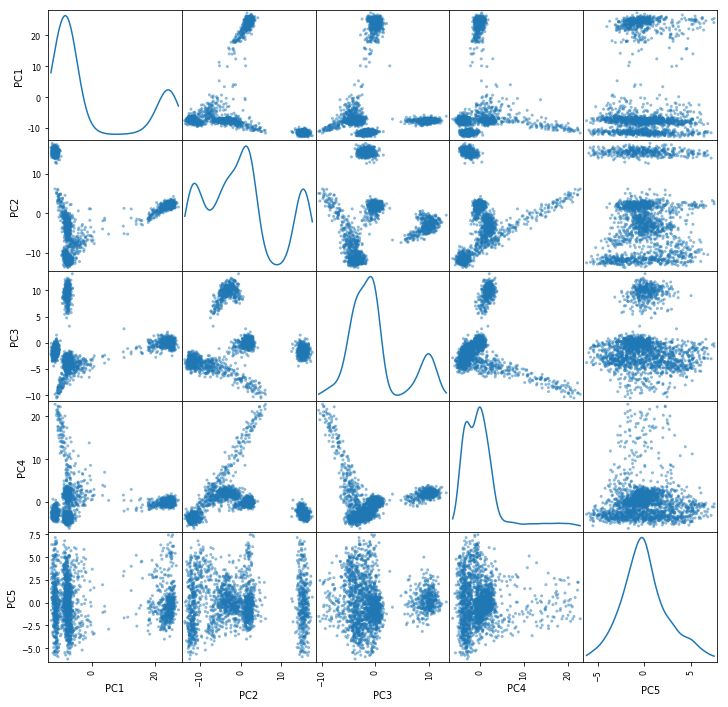

In [61]:
plotting_df = pd.DataFrame(data=X_train_principle_components[:, :5],
                          columns=['PC1', 'PC2', 'PC3', 'PC4', 'PC5'])
axs = pd.plotting.scatter_matrix(plotting_df, figsize=(12,12), diagonal='kde')

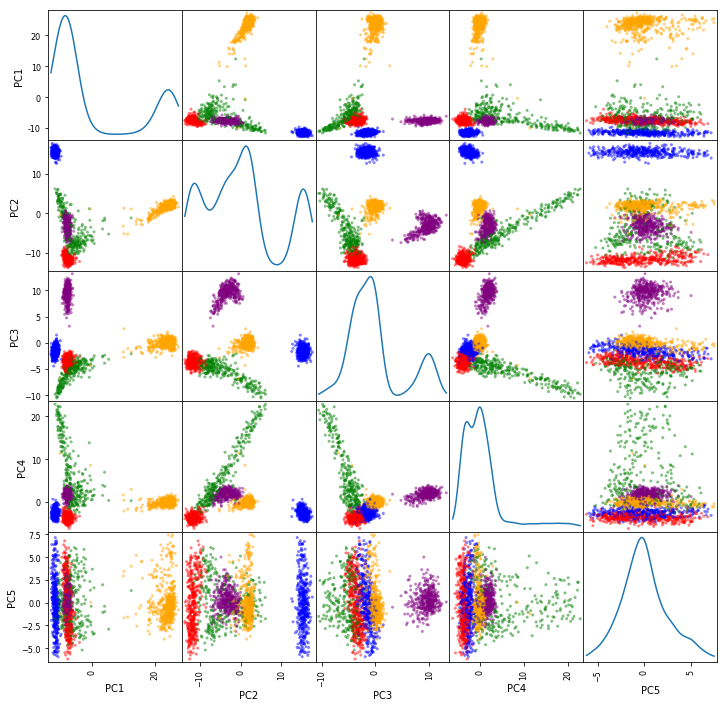

In [62]:
ancestry_to_color = {'european': 'red',
                     'east asian': 'blue',
                     'south/north american': 'green',
                     'african': 'orange',
                     'south asian': 'purple'}

colors = [ancestry_to_color[sample_id_to_ancestry[s_id]]
          for s_id in X_train_df.index]

axs = pd.plotting.scatter_matrix(plotting_df, color=colors,
                           figsize=(12,12), diagonal='kde')

## Classifier #2

In [63]:
# normalize our continuous variables
scaler = StandardScaler()
scaler.fit(X_train_principle_components)

X_train_principle_components = scaler.transform(X_train_principle_components)

X_train_principle_components

array([[-0.53697137, -1.3038089 , -1.08725678, ..., -0.18946087,
        -0.33515559,  0.3117448 ],
       [-0.51113088, -0.34616898,  2.04358227, ...,  0.78797459,
        -0.77205865,  0.69287265],
       [ 1.56114705,  0.1345005 ,  0.05588465, ..., -0.67499781,
         1.25834933, -1.76338552],
       ...,
       [ 1.66572283,  0.2051672 , -0.03050412, ...,  0.95532542,
        -0.89071453, -0.27833763],
       [ 1.71161455,  0.18687696,  0.03134891, ...,  0.68141955,
        -0.20417581, -1.48302539],
       [-0.49486604, -0.03251846,  1.84759028, ..., -0.74442084,
         0.66673634,  0.41540493]])

In [64]:
# train our new model
clf = RandomForestClassifier(n_estimators=100)
clf.fit(X_train_principle_components, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [65]:
# test our new model
X_test_principle_components = pca.transform(X_test)

X_test_principle_components = scaler.transform(X_test_principle_components)

clf.score(X_test_principle_components, np.reshape(y_test, (y_test.shape[0],)))

0.9920159680638723